# Planet Viewing Example

This example shows how to plot geometric quantities using the frames system.


First we import numpy and the plotting module.

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

Then we import GODOT modules and create a universe from configuration.

The [universe](./universe.yml) contains an entry to insert a keplerian orbit point, named 'SC' into the frames system.

In [3]:
from godot.core import tempo, astro, events
from godot import cosmos
from godot.model import eventgen

# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

# create the universe
uni_config = cosmos.util.load_yaml('universe2.yml')
uni = cosmos.Universe(uni_config)

We setup the universe as defined in the yml file.
Furthermore we define a timespan, here one month, evaluated in 30 seconds timesteps.

In [4]:
#Setup
uni_config = cosmos.util.load_yaml('universe2.yml')
uni = cosmos.Universe(uni_config)

# specify a time grid
ep1 = tempo.Epoch('2026-04-01T00:00:00 TDB')
ep2 = tempo.Epoch('2026-05-01T00:00:00 TDB')
ran = tempo.EpochRange( ep1, ep2 )
grid = ran.createGrid(30.0) # 30 seconds stepsize
eps = 1e-6
tol = 1e-6
event_grid = ran.contract(eps).createGrid(30.0)

Events are evaluated as
$$
g(t) > 0
$$

Event interval are evaluated as time periods where this is true

Besides the earth hiding, we want to know wether the moon blocks the view of the spacecraft. This can be done by calculating if the vector between the ground station and the SC intersects the surface of the moon. If the vector does, and the spacecraft is closer to the groundstation than the moon, it is still visible

In [5]:
import godot.core.astro as astro 
import godot.core.events as events
#Fungerer ikke helt med mine goals
import numpy as np

# Alias for Cebreros
groundStation = 'CB11'
def sphere_intersection(camera_pos, direction, radius = 1737.4):
    """Calculate the intersection of a vector from the camera position with a sphere."""
    direction = direction / np.linalg.norm(direction)  # Normalize direction
    b = 2 * np.dot(camera_pos, direction)
    c = np.dot(camera_pos, camera_pos) - radius**2
    discriminant = b**2 - 4 * c
    
    if discriminant < 0:
        return None  # No intersection
    t_1 = (-b - np.sqrt(discriminant))/2
    t_2 = (-b + np.sqrt(discriminant))/2

    t = t_1 if abs(t_1) < np.abs(t_2) else t_2     
    intersection = camera_pos + t * direction
    return intersection

def CBSCnotBlockedByMoon( epo ):
    # Vector from moon to ground station
    GS = uni.frames.vector3('Moon', groundStation, 'ICRF', epo)
    # Vector from moon to space craft
    SC = uni.frames.vector3('Moon', 'SC', 'ICRF', epo)
    res = sphere_intersection(GS, GS-SC)
    if (res is None):
        return 1
    int_dist = np.sqrt(np.sum(np.power(GS - res,2)))
    sc_dist = np.sqrt(np.sum(np.power(GS-SC,2)))
    #print(f"Intersection distance: {int_dist}, spacecraft distance: {sc_dist}, closer?: {sc_dist < int_dist}")
    closer = sc_dist < int_dist
    if closer:
        return 1
    else:
        return -1

Time: 2026-04-02T01:00:00.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-04-02T01:00:00.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-04-02T01:00:00.000000 TDB - Does moon block: No, does earth block: No


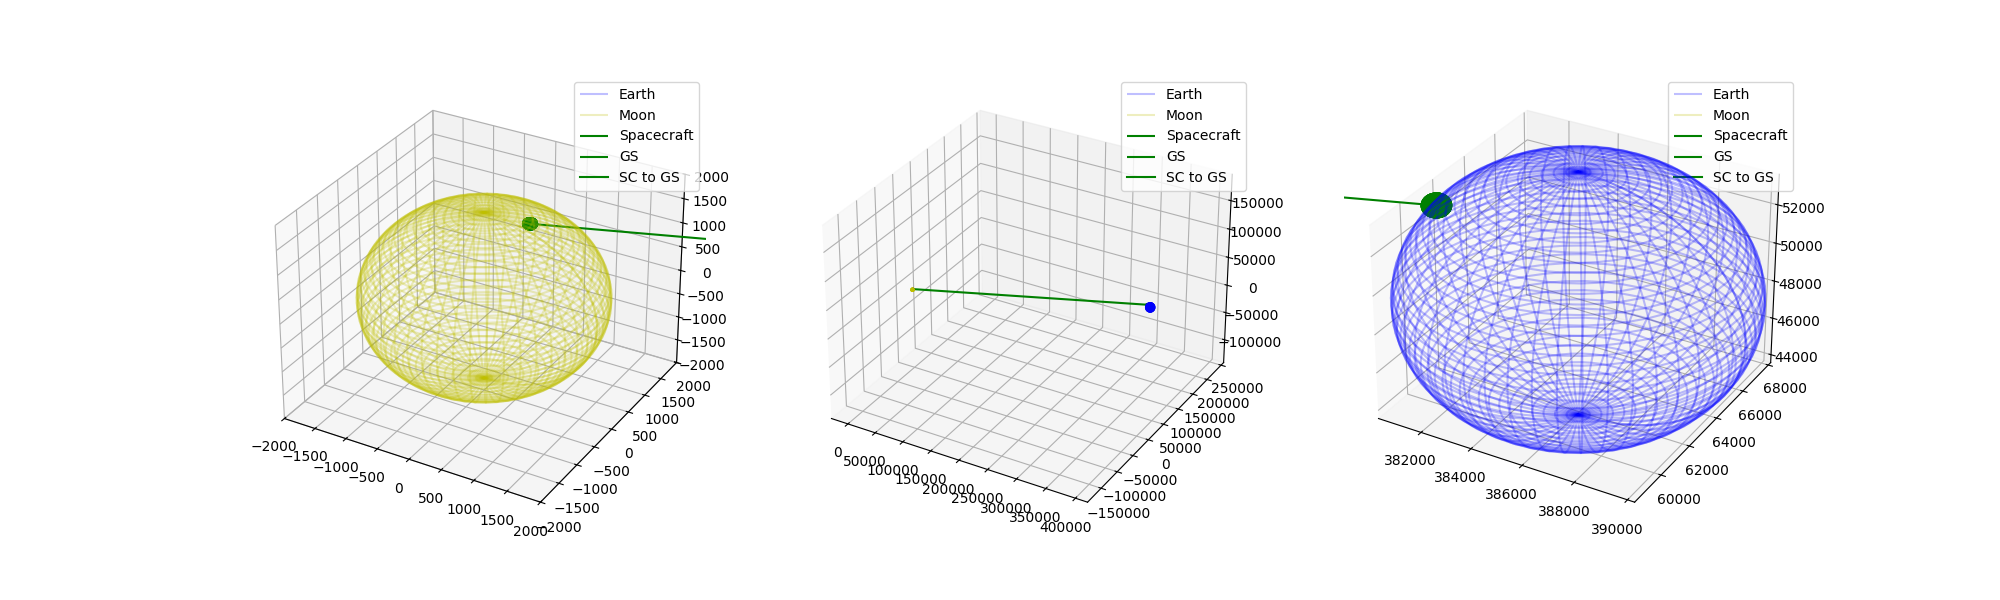

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import godot

def plot_sphere(coordinates, radius, ax, label, alpha, c):
    """Helper function to plot a sphere."""
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = coordinates[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = coordinates[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = coordinates[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, alpha=alpha, label=label,color=c)

def plot_scenario(t, ax):
    GS = uni.frames.vector3('Moon', groundStation, 'ICRF', t)
    GSE = uni.frames.vector3('Earth', groundStation, 'ICRF', t)
    EarthCentre = uni.frames.vector3('Moon', 'Earth', 'ICRF', t)
    spacecraft = uni.frames.vector3('Moon', 'SC', 'ICRF', t)
    mooncentre = [0, 0, 0]

    # Visibility checks
    moonVisible = CBSCnotBlockedByMoon(t)
    model = uni.evaluables["Cebreros_Moon_Elevation"]
    elevation = np.degrees(model.eval(t))

    print(f"Time: {t} - Does moon block: {'Yes' if moonVisible < 0 else 'No'}, does earth block: {'Yes' if elevation < 10 else 'No'}")

    # Plot spheres
    plot_sphere(EarthCentre, np.linalg.norm(GSE), ax, 'Earth', 0.25, 'b')
    plot_sphere(mooncentre, 1737.4, ax, 'Moon', 0.25, 'y')
    c = 'g' if moonVisible > 0  else 'r'
    plot_sphere(spacecraft, 100, ax, 'Spacecraft', 1, c)
    c = 'g' if elevation > 10 else 'r'
    plot_sphere(EarthCentre + GSE, 500, ax, 'GS', 1, c)

    # Plot vector from spacecraft to ground station
    vec = np.linspace(spacecraft, EarthCentre + GSE, 100)
    c = 'g' if moonVisible > 0 and elevation > 10 else 'r'
    ax.plot(vec[:, 0], vec[:, 1], vec[:, 2], label="SC to GS", c=c)
    
    ax.legend()
    return fig, ax, EarthCentre, mooncentre

def set_view(earthcentre, mooncentre,ax, view):
    """Set axis limits based on the desired view."""
    vd_earth = 5000
    vd_moon = 2000
    if view == "Earth":
        ax.set_xlim([earthcentre[0]-vd_earth, earthcentre[0]+vd_earth])
        ax.set_ylim([earthcentre[1]-vd_earth, earthcentre[1]+vd_earth])
        ax.set_zlim([earthcentre[2]-vd_earth, earthcentre[2]+vd_earth])
    elif view == "Moon":
        ax.set_xlim([mooncentre[0]-vd_moon, mooncentre[0]+vd_moon])
        ax.set_ylim([mooncentre[1]-vd_moon, mooncentre[1]+vd_moon])
        ax.set_zlim([mooncentre[2]-vd_moon, mooncentre[2]+vd_moon])

# Example usage
t = godot.core.tempo.Epoch('2026-05-01T10:00:00 TDB')
t = godot.core.tempo.Epoch('2026-04-02T01:00:00 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(20,6))
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.show()

Time: 2026-04-02T17:20:00.000000 TDB - Does moon block: No, does earth block: Yes
Time: 2026-04-02T17:20:00.000000 TDB - Does moon block: No, does earth block: Yes
Time: 2026-04-02T17:20:00.000000 TDB - Does moon block: No, does earth block: Yes


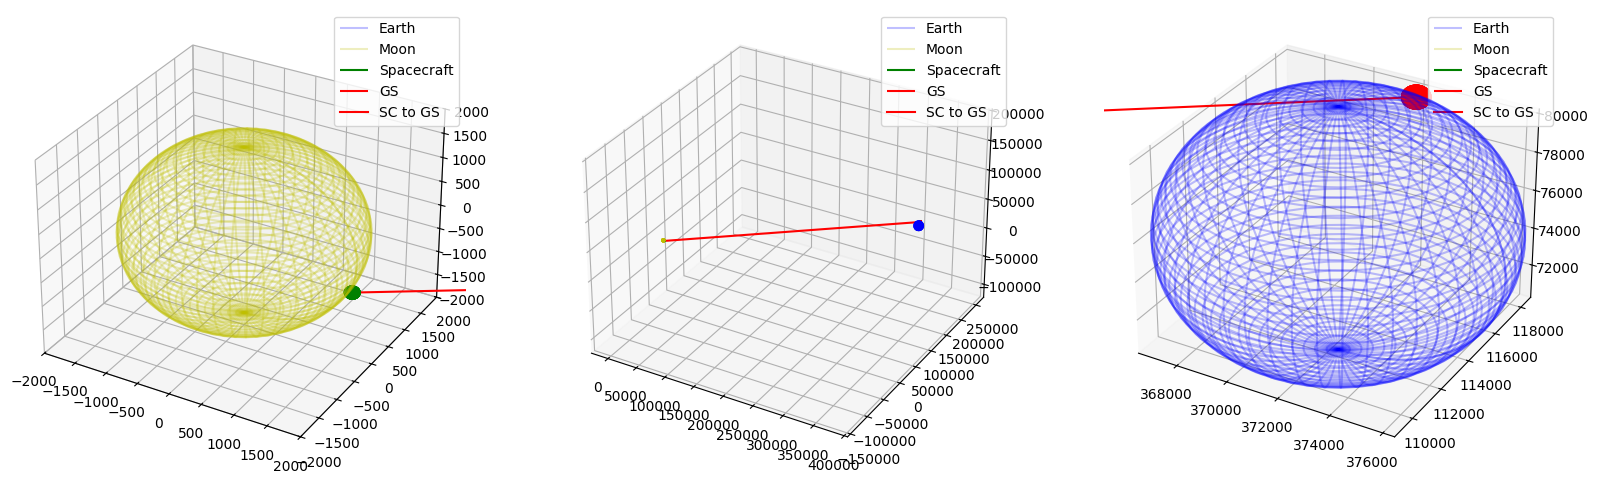

In [53]:
# Example usage
t = godot.core.tempo.Epoch('2026-04-02T17:20:00 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(20,60))
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.show()

Time: 2026-04-02T01:30:00.000000 TDB - Does moon block: Yes, does earth block: No
Time: 2026-04-02T01:30:00.000000 TDB - Does moon block: Yes, does earth block: No
Time: 2026-04-02T01:30:00.000000 TDB - Does moon block: Yes, does earth block: No


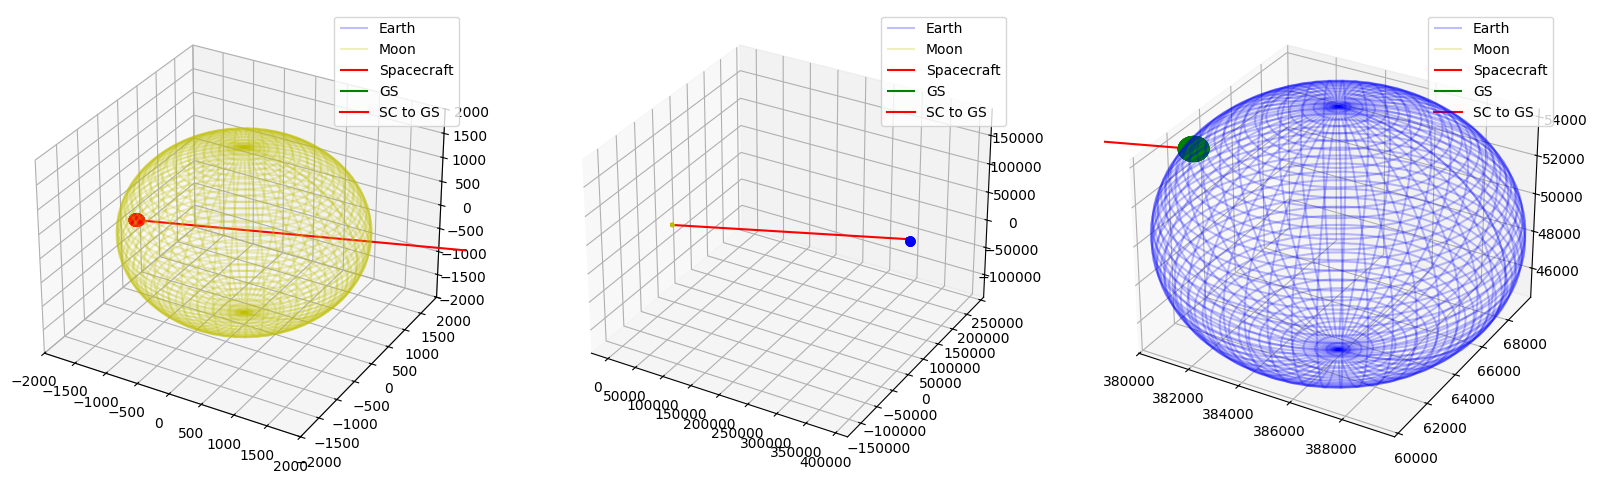

In [54]:
# Example usage
t = godot.core.tempo.Epoch('2026-04-02T01:30:00 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(20,60))
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.show()

Time: 2026-09-02T01:14:01.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-09-02T01:14:01.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-09-02T01:14:01.000000 TDB - Does moon block: No, does earth block: No


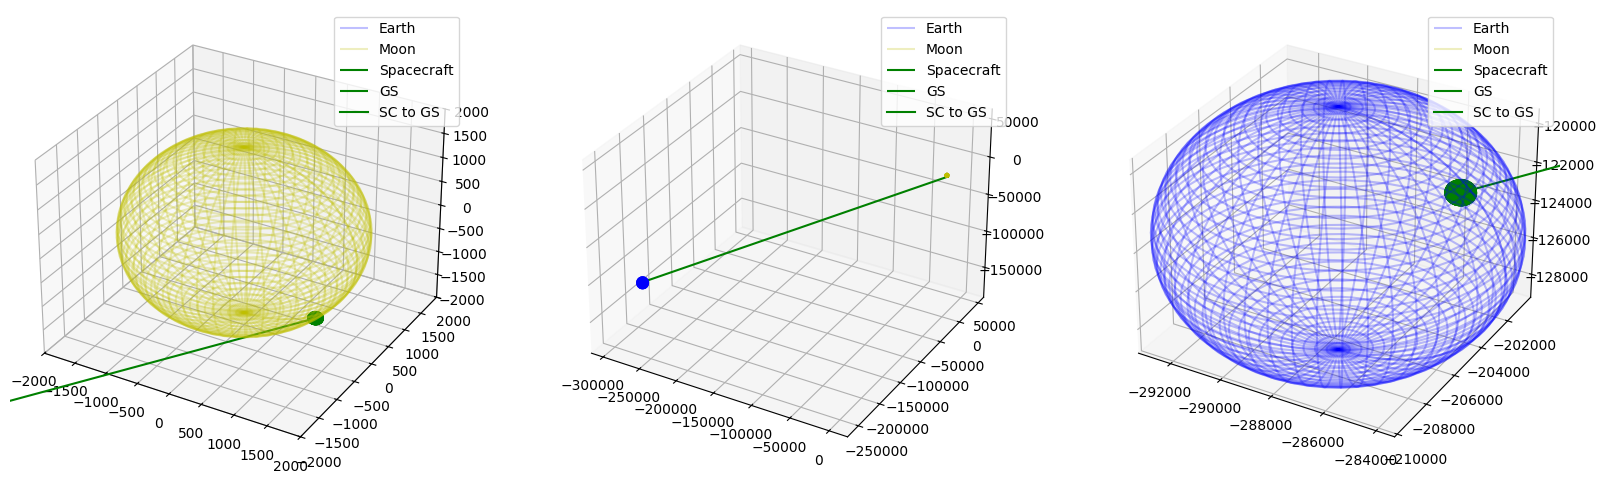

In [66]:
# Example usage
t = godot.core.tempo.Epoch('2026-09-02T01:14:01 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(20,60))
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.show()

Time: 2026-09-02T10:40:01.000000 TDB - Does moon block: No, does earth block: Yes
Time: 2026-09-02T10:40:01.000000 TDB - Does moon block: No, does earth block: Yes
Time: 2026-09-02T10:40:01.000000 TDB - Does moon block: No, does earth block: Yes


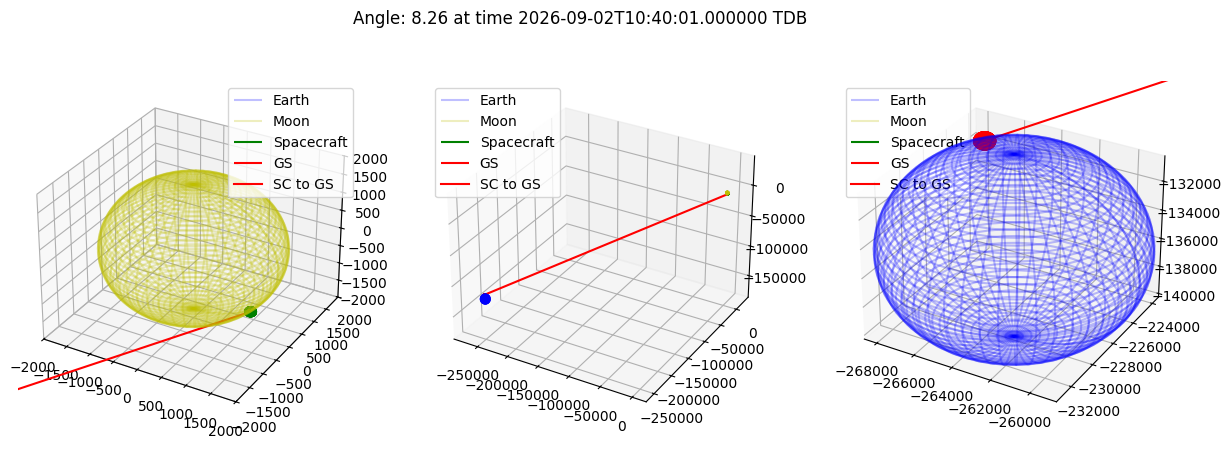

Time: 2026-09-02T10:30:01.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-09-02T10:30:01.000000 TDB - Does moon block: No, does earth block: No
Time: 2026-09-02T10:30:01.000000 TDB - Does moon block: No, does earth block: No


<Figure size 640x480 with 0 Axes>

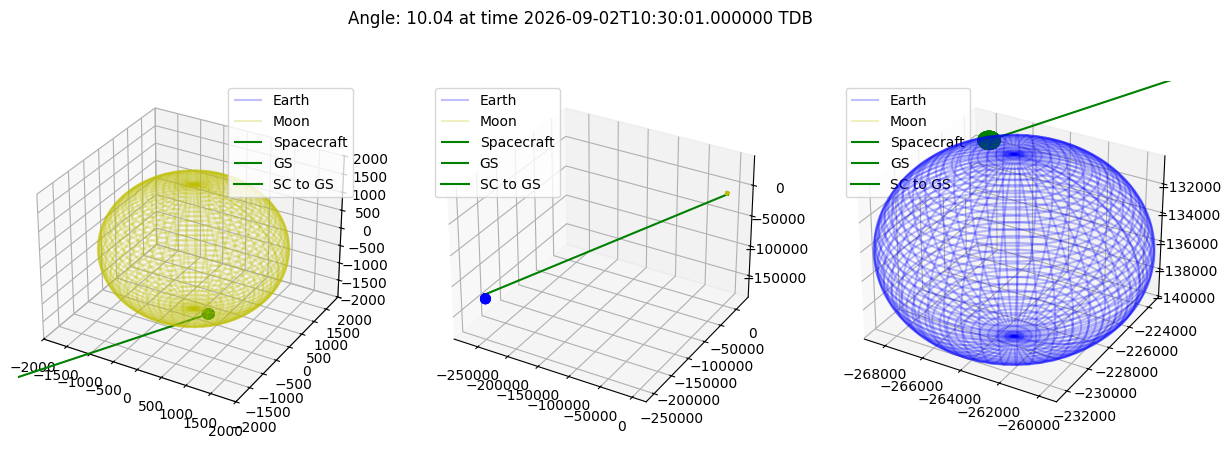

In [103]:
# Example usage
t = godot.core.tempo.Epoch('2026-09-02T10:40:01 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(15,5))

GSE = uni.frames.vector3(groundStation, 'Earth', 'ICRF', t)
GSSC = uni.frames.vector3(groundStation, 'SC', 'ICRF', t)
A = np.degrees(np.arccos(np.dot(GSE,GSSC)/(np.linalg.norm(GSE)*np.linalg.norm(GSSC))))-90
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.suptitle(f"Angle: {A:.2f} at time {t}")
plt.show()

plt.figure()
t = godot.core.tempo.Epoch('2026-09-02T10:30:01 TDB')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(15,5))
GSE = uni.frames.vector3(groundStation, 'Earth', 'ICRF', t)
GSSC = uni.frames.vector3(groundStation, 'SC', 'ICRF', t)
A = np.degrees(np.arccos(np.dot(GSE,GSSC)/(np.linalg.norm(GSE)*np.linalg.norm(GSSC))))-90
plt.subplot(1,3,1)
fig, ax, ec, mc = plot_scenario(t, ax1)
set_view(ec,mc,ax1, "Moon")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax2)
set_view(ec,mc,ax2, "")
plt.subplot(1,3,2)
fig, ax, ec, mc = plot_scenario(t, ax3)
set_view(ec,mc,ax3, "Earth")
plt.axis('equal')
plt.suptitle(f"Angle: {A:.2f} at time {t}")
plt.show()